# Import and Functions

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import requests
from bs4 import BeautifulSoup
# import pandas_profiling
import sklearn
import boto3
from boto3 import session

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics, preprocessing, pipeline
from sklearn.pipeline import make_union, make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score, r2_score
from sklearn.neighbors import KNeighborsClassifier

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy 

import matplotlib.pyplot as plt 
# %matplotlib inline
import seaborn as sns
import plotly

import re
import sys
import datetime as dt
import time
from time import sleep

import fancyimpute
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler
# documentation: https://pypi.org/project/fancyimpute/

Using TensorFlow backend.


In [2]:
#Exploratory Data Analysis

def get_variable_category(series):
    unique_count = series.nunique(dropna=False)
    total_count = len(series)
    if pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif unique_count==total_count:
        return 'Text (Unique)'
    else:
        return 'Categorical'

def print_variable_categories(data):
    for column_name in data.columns:
        print(column_name, ': ', get_variable_category(data[column_name]))
        
def datainspect(dataframe):
    '''Inspect data'''
    print('ROWS AND COLUMNS: \n', dataframe.shape,'\n')
    print('MISSING VALUES: \n', dataframe.isnull().sum(),'\n')
    print('DUPLICATE ROWS \n', dataframe.duplicated().sum(),'\n') 
    print('DATA TYPES: \n', dataframe.dtypes,"\n")
    print('DATAFRAME DESCRIBE: \n \n', dataframe.describe(include='all'),'\n')
    print('UNIQUE VALUES:')
    for item in dataframe:
        print(item, dataframe[item].nunique())
    print('\n')
    print('VARIABLE CATEGORIES:', '\n' )
    print(print_variable_categories(dataframe))


# Datasets

## Submission Forecast Period
???

## Submission Format
???

## Historical Consumption  
A selected time series of consumption data for over 200 buildings.

**obs_id** - An arbitrary ID for the observations   
**SiteId** - An arbitrary ID number for the building, matches across datasets  
**ForecastId** - An ID for a timeseries that is part of a forecast (can be matched with the submission file)  
**Timestamp** - The time of the measurement  
**Value** - A measure of consumption for that building  
  

## Building Metadata
Additional information about the included buildings.

**SiteId** - An arbitrary ID number for the building, matches across datasets  
**Surface** - The surface area of the building  
**Sampling** - The number of minutes between each observation for this site. The timestep size for each ForecastId can be found in the separate "Submission Forecast Period" file on the data download page.  
**BaseTemperature** - The base temperature for the building  
**[DAY_OF_WEEK]IsDayOff** - True if DAY_OF_WEEK is not a work day  

## Historical Weather Data
This dataset contains temperature data from several stations near each site. For each site several temperature measurements were retrieved from stations in a radius of 30 km if available.

*Note:* Not all sites will have available weather data.

*Note:* Weather data is available for test periods under the assumption that reasonably accurate forecasts will be available to algorithms that the time that we are attempting to make predictions about the future.

**SiteId** - An arbitrary ID number for the building, matches across datasets  
**Timestamp** - The time of the measurement  
**Temperature** - The temperature as measured at the weather station  
**Distance** - The distance in km from the weather station to the building in km  

## Public Holidays
Public holidays at the sites included in the dataset, which may be helpful for identifying days where consumption may be lower than expected.

*Note:* Not all sites will have available public holiday data.

**SiteId** - An arbitrary ID number for the building, matches across datasets  
**Timestamp** - The date of the holiday  
**Holiday** - The name of the holiday

# Submission Forecast Period (??)

In [3]:
submission_forecast_period = pd.read_csv('../data/submission_forecast_period.csv', sep = ';')
submission_forecast_period.head()

,ForecastId,ForecastPeriodNS
0,18,3600000000000
1,58,900000000000
2,64,900000000000
3,89,900000000000
4,101,900000000000


In [4]:
datainspect(submission_forecast_period)

ROWS AND COLUMNS: 
 (6974, 2) 

MISSING VALUES: 
 ForecastId          0
ForecastPeriodNS    0
dtype: int64 

DUPLICATE ROWS 
 0 

DATA TYPES: 
 ForecastId          int64
ForecastPeriodNS    int64
dtype: object 

DATAFRAME DESCRIBE: 
 
         ForecastId  ForecastPeriodNS
count  6974.000000      6.974000e+03
mean   3487.500000      4.151821e+12
std    2013.364721      1.502076e+13
min       1.000000      9.000000e+11
25%    1744.250000      9.000000e+11
50%    3487.500000      9.000000e+11
75%    5230.750000      9.000000e+11
max    6974.000000      8.640000e+13 

UNIQUE VALUES:
ForecastId 6974
ForecastPeriodNS 3


VARIABLE CATEGORIES: 

ForecastId :  Numerical
ForecastPeriodNS :  Numerical
None


# Submission Format (??)

In [5]:
submission_format = pd.read_csv('../data/submission_format.csv', sep = ';')
submission_format['Timestamp'] = pd.to_datetime(submission_format['Timestamp'])
submission_format.head()

,obs_id,SiteId,Timestamp,ForecastId,Value
0,2535749,143,2017-08-28,3146,0.0
1,7300088,143,2017-08-28,3146,0.0
2,1465337,143,2017-08-28,3146,0.0
3,4747700,143,2017-08-28,3146,0.0
4,6008051,143,2017-08-28,3146,0.0


In [6]:
datainspect(submission_format)

ROWS AND COLUMNS: 
 (1309176, 5) 

MISSING VALUES: 
 obs_id        0
SiteId        0
Timestamp     0
ForecastId    0
Value         0
dtype: int64 

DUPLICATE ROWS 
 0 

DATA TYPES: 
 obs_id                 int64
SiteId                 int64
Timestamp     datetime64[ns]
ForecastId             int64
Value                float64
dtype: object 

DATAFRAME DESCRIBE: 
 
               obs_id        SiteId            Timestamp    ForecastId  \
count   1.309176e+06  1.309176e+06              1309176  1.309176e+06   
unique           NaN           NaN                 2269           NaN   
top              NaN           NaN  2016-07-26 00:00:00           NaN   
freq             NaN           NaN                 2597           NaN   
first            NaN           NaN  2009-08-02 00:00:00           NaN   
last             NaN           NaN  2017-12-28 00:00:00           NaN   
mean    3.931478e+06  1.621134e+02                  NaN  3.482680e+03   
std     2.271962e+06  9.393814e+01              

# Holidays

In [7]:
holidays = pd.read_csv('../data/holidays.csv', sep = ';')
holidays['Date'] = pd.to_datetime(holidays['Date'])
holidays.rename(columns={'Date': 'Timestamp'}, inplace=True)
holidays.head()

,Timestamp,Holiday,SiteId
0,2015-05-01,Workers Day,189
1,2015-09-24,Heritage Day,189
2,2017-01-02,New year substitute,190
3,2017-08-09,National Women Day,190
4,2017-12-26,Boxing Day,190


In [8]:
datainspect(holidays)

ROWS AND COLUMNS: 
 (8387, 3) 

MISSING VALUES: 
 Timestamp    0
Holiday      0
SiteId       0
dtype: int64 

DUPLICATE ROWS 
 0 

DATA TYPES: 
 Timestamp    datetime64[ns]
Holiday              object
SiteId                int64
dtype: object 

DATAFRAME DESCRIBE: 
 
                   Timestamp   Holiday       SiteId
count                  8387      8387  8387.000000
unique                  346       110          NaN
top     2016-12-26 00:00:00  New year          NaN
freq                    253       707          NaN
first   2009-01-01 00:00:00       NaN          NaN
last    2018-01-01 00:00:00       NaN          NaN
mean                    NaN       NaN   156.675808
std                     NaN       NaN    85.650221
min                     NaN       NaN     1.000000
25%                     NaN       NaN    87.000000
50%                     NaN       NaN   157.000000
75%                     NaN       NaN   216.000000
max                     NaN       NaN   305.000000 

UNIQUE VALUES:


In [9]:
holidays['IsHoliday'] = 1
holidays.head()

,Timestamp,Holiday,SiteId,IsHoliday
0,2015-05-01,Workers Day,189,1
1,2015-09-24,Heritage Day,189,1
2,2017-01-02,New year substitute,190,1
3,2017-08-09,National Women Day,190,1
4,2017-12-26,Boxing Day,190,1


# Metadata

In [10]:
metadata = pd.read_csv('../data/metadata.csv', sep = ';')
metadata.head()

,SiteId,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff
0,25,2201.924904,15.0,18.0,False,False,False,False,False,True,True
1,49,1046.032846,15.0,18.0,False,False,False,False,False,True,True
2,73,1278.139659,15.0,18.0,False,False,False,False,False,True,True
3,105,15684.678378,10.0,18.0,False,False,False,False,False,True,True
4,117,18772.751947,15.0,18.0,False,False,False,False,False,False,False


In [11]:
metadata['MondayIsDayOff'] = metadata['MondayIsDayOff'].astype(int)
metadata['TuesdayIsDayOff'] = metadata['TuesdayIsDayOff'].astype(int)
metadata['WednesdayIsDayOff'] = metadata['WednesdayIsDayOff'].astype(int)
metadata['ThursdayIsDayOff'] = metadata['ThursdayIsDayOff'].astype(int)
metadata['FridayIsDayOff'] = metadata['FridayIsDayOff'].astype(int)
metadata['SaturdayIsDayOff'] = metadata['SaturdayIsDayOff'].astype(int)
metadata['SundayIsDayOff'] = metadata['SundayIsDayOff'].astype(int)

datainspect(metadata)

ROWS AND COLUMNS: 
 (267, 11) 

MISSING VALUES: 
 SiteId               0
Surface              0
Sampling             0
BaseTemperature      0
MondayIsDayOff       0
TuesdayIsDayOff      0
WednesdayIsDayOff    0
ThursdayIsDayOff     0
FridayIsDayOff       0
SaturdayIsDayOff     0
SundayIsDayOff       0
dtype: int64 

DUPLICATE ROWS 
 0 

DATA TYPES: 
 SiteId                 int64
Surface              float64
Sampling             float64
BaseTemperature      float64
MondayIsDayOff         int64
TuesdayIsDayOff        int64
WednesdayIsDayOff      int64
ThursdayIsDayOff       int64
FridayIsDayOff         int64
SaturdayIsDayOff       int64
SundayIsDayOff         int64
dtype: object 

DATAFRAME DESCRIBE: 
 
            SiteId       Surface    Sampling  BaseTemperature  MondayIsDayOff  \
count  267.000000    267.000000  267.000000       267.000000           267.0   
mean   157.719101   7894.541319   14.438202        18.026217             0.0   
std     88.781093   9744.769014    4.715887     

In [12]:
metadata.head()

,SiteId,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff
0,25,2201.924904,15.0,18.0,0,0,0,0,0,1,1
1,49,1046.032846,15.0,18.0,0,0,0,0,0,1,1
2,73,1278.139659,15.0,18.0,0,0,0,0,0,1,1
3,105,15684.678378,10.0,18.0,0,0,0,0,0,1,1
4,117,18772.751947,15.0,18.0,0,0,0,0,0,0,0


In [13]:
def dayoff(dataframe):
    print('MONDAY IS A DAY OFF: \n', dataframe.MondayIsDayOff.value_counts(),'\n')
    print('TUESDAY IS A DAY OFF: \n', dataframe.TuesdayIsDayOff.value_counts(),'\n')
    print('WEDNESDAY IS A DAY OFF: \n', dataframe.WednesdayIsDayOff.value_counts(),'\n')
    print('THURSDAY IS A DAY OFF: \n', dataframe.ThursdayIsDayOff.value_counts(),'\n')
    print('FRIDAY IS A DAY OFF: \n', dataframe.FridayIsDayOff.value_counts(),'\n')
    print('SATURDAY IS A DAY OFF: \n', dataframe.SaturdayIsDayOff.value_counts(),'\n')
    print('SUNDAY IS A DAY OFF: \n', dataframe.SundayIsDayOff.value_counts(),'\n')

In [14]:
dayoff(metadata)

MONDAY IS A DAY OFF: 
 0    267
Name: MondayIsDayOff, dtype: int64 

TUESDAY IS A DAY OFF: 
 0    267
Name: TuesdayIsDayOff, dtype: int64 

WEDNESDAY IS A DAY OFF: 
 0    267
Name: WednesdayIsDayOff, dtype: int64 

THURSDAY IS A DAY OFF: 
 0    267
Name: ThursdayIsDayOff, dtype: int64 

FRIDAY IS A DAY OFF: 
 0    266
1      1
Name: FridayIsDayOff, dtype: int64 

SATURDAY IS A DAY OFF: 
 1    254
0     13
Name: SaturdayIsDayOff, dtype: int64 

SUNDAY IS A DAY OFF: 
 1    258
0      9
Name: SundayIsDayOff, dtype: int64 



# Training Data

In [15]:
training_data = pd.read_csv('../data/training_data.csv', sep = ';')
training_data['Timestamp'] = pd.to_datetime(training_data['Timestamp'])
training_data.head()

,obs_id,SiteId,Timestamp,ForecastId,Value
0,7385825,295,2016-12-13,6576,120000.030698
1,5463619,295,2016-12-13,6576,54419.278745
2,339589,295,2016-12-13,6576,35351.037846
3,3952414,295,2016-12-13,6576,21932.474447
4,7222988,295,2016-12-14,6576,19379.923271


In [16]:
datainspect(training_data)

ROWS AND COLUMNS: 
 (6559830, 5) 

MISSING VALUES: 
 obs_id            0
SiteId            0
Timestamp         0
ForecastId        0
Value         86601
dtype: int64 

DUPLICATE ROWS 
 0 

DATA TYPES: 
 obs_id                 int64
SiteId                 int64
Timestamp     datetime64[ns]
ForecastId             int64
Value                float64
dtype: object 

DATAFRAME DESCRIBE: 
 
               obs_id        SiteId            Timestamp    ForecastId  \
count   6.559830e+06  6.559830e+06              6559830  6.559830e+06   
unique           NaN           NaN                 2931           NaN   
top              NaN           NaN  2016-07-08 00:00:00           NaN   
freq             NaN           NaN                 7358           NaN   
first            NaN           NaN  2009-06-23 00:00:00           NaN   
last             NaN           NaN  2017-12-08 00:00:00           NaN   
mean    3.935106e+06  1.620964e+02                  NaN  3.482184e+03   
std     2.271511e+06  9.3921

In [17]:
# Missing Data - when less than 5% of data is missing we can drop observations
pct_missing = (86601/6559830)*100
print(pct_missing)

training_data = training_data.dropna()
datainspect(training_data)

1.320171406880971
ROWS AND COLUMNS: 
 (6473229, 5) 

MISSING VALUES: 
 obs_id        0
SiteId        0
Timestamp     0
ForecastId    0
Value         0
dtype: int64 

DUPLICATE ROWS 
 0 

DATA TYPES: 
 obs_id                 int64
SiteId                 int64
Timestamp     datetime64[ns]
ForecastId             int64
Value                float64
dtype: object 

DATAFRAME DESCRIBE: 
 
               obs_id        SiteId            Timestamp    ForecastId  \
count   6.473229e+06  6.473229e+06              6473229  6.473229e+06   
unique           NaN           NaN                 2931           NaN   
top              NaN           NaN  2016-07-08 00:00:00           NaN   
freq             NaN           NaN                 7335           NaN   
first            NaN           NaN  2009-06-23 00:00:00           NaN   
last             NaN           NaN  2017-12-08 00:00:00           NaN   
mean    3.935129e+06  1.621301e+02                  NaN  3.482654e+03   
std     2.271496e+06  9.384759

**Inspecting the Training Data:**


*   There are no missing values
*   Multiple time-stamps for same Site-id



# Weather

In [18]:
weather = pd.read_csv('../data/weather.csv', sep = ';')
weather.head()

,Timestamp,Temperature,Distance,SiteId
0,2016-11-10T14:50:00-05:00,17.0,18.071988,278
1,2016-11-10T17:20:00-05:00,15.0,18.071988,278
2,2016-11-10T18:00:00-05:00,14.6,20.641517,278
3,2016-11-11T18:50:00-05:00,14.0,18.071988,278
4,2016-11-11T23:20:00-05:00,10.0,18.071988,278


In [19]:
# I have no idea what the last few digits of this time stamp mean.
# For now I'm going to remove them so I can convert the rest of it but saving it in a new column
weather['weatherTimeSuffix'] = weather['Timestamp'].str[-5:]
weather['Timestamp'] = weather['Timestamp'].str[:-6]
weather['Timestamp'] = weather['Timestamp'].str.replace('T',' ')
weather.head()

,Timestamp,Temperature,Distance,SiteId,weatherTimeSuffix
0,2016-11-10 14:50:00,17.0,18.071988,278,05:00
1,2016-11-10 17:20:00,15.0,18.071988,278,05:00
2,2016-11-10 18:00:00,14.6,20.641517,278,05:00
3,2016-11-11 18:50:00,14.0,18.071988,278,05:00
4,2016-11-11 23:20:00,10.0,18.071988,278,05:00


In [20]:
weather['Timestamp'] = pd.to_datetime(weather['Timestamp'])
weather.head()

,Timestamp,Temperature,Distance,SiteId,weatherTimeSuffix
0,2016-11-10 14:50:00,17.0,18.071988,278,05:00
1,2016-11-10 17:20:00,15.0,18.071988,278,05:00
2,2016-11-10 18:00:00,14.6,20.641517,278,05:00
3,2016-11-11 18:50:00,14.0,18.071988,278,05:00
4,2016-11-11 23:20:00,10.0,18.071988,278,05:00


In [21]:
weather['Timestamp_full'] = weather['Timestamp']
weather['Timestamp'] = weather['Timestamp_full'].apply(lambda x: x.date())

In [22]:
weather.head()

,Timestamp,Temperature,Distance,SiteId,weatherTimeSuffix,Timestamp_full
0,2016-11-10,17.0,18.071988,278,05:00,2016-11-10 14:50:00
1,2016-11-10,15.0,18.071988,278,05:00,2016-11-10 17:20:00
2,2016-11-10,14.6,20.641517,278,05:00,2016-11-10 18:00:00
3,2016-11-11,14.0,18.071988,278,05:00,2016-11-11 18:50:00
4,2016-11-11,10.0,18.071988,278,05:00,2016-11-11 23:20:00


In [23]:
datainspect(weather)

ROWS AND COLUMNS: 
 (19911985, 6) 

MISSING VALUES: 
 Timestamp            0
Temperature          0
Distance             0
SiteId               0
weatherTimeSuffix    0
Timestamp_full       0
dtype: int64 

DUPLICATE ROWS 
 0 

DATA TYPES: 
 Timestamp                    object
Temperature                 float64
Distance                    float64
SiteId                        int64
weatherTimeSuffix            object
Timestamp_full       datetime64[ns]
dtype: object 

DATAFRAME DESCRIBE: 
 
          Timestamp   Temperature      Distance        SiteId  \
count     19911985  1.991198e+07  1.991198e+07  1.991198e+07   
unique        3288           NaN           NaN           NaN   
top     2016-09-22           NaN           NaN           NaN   
freq         17874           NaN           NaN           NaN   
first          NaN           NaN           NaN           NaN   
last           NaN           NaN           NaN           NaN   
mean           NaN  1.526614e+01  1.607478e+01  1.6681

# Merging

In [24]:
merge = pd.merge(training_data, submission_forecast_period, how = 'left', on = ['ForecastId'])
merge = pd.merge(merge, metadata, how = 'left', left_on = ['SiteId'], right_on = ['SiteId'])
merge.head()

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodNS,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff
0,7385825,295,2016-12-13,6576,120000.030698,900000000000,10814.258273,10.0,18.0,0,0,0,0,0,1,1
1,5463619,295,2016-12-13,6576,54419.278745,900000000000,10814.258273,10.0,18.0,0,0,0,0,0,1,1
2,339589,295,2016-12-13,6576,35351.037846,900000000000,10814.258273,10.0,18.0,0,0,0,0,0,1,1
3,3952414,295,2016-12-13,6576,21932.474447,900000000000,10814.258273,10.0,18.0,0,0,0,0,0,1,1
4,7222988,295,2016-12-14,6576,19379.923271,900000000000,10814.258273,10.0,18.0,0,0,0,0,0,1,1


In [25]:
# left join, preserves all rows from training_data
training_merged = pd.merge(merge, holidays, how = 'left', left_on = ['SiteId', 'Timestamp'], right_on = ['SiteId', 'Timestamp'])
print(training_merged.shape)
training_merged.head()

(6476973, 18)


,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodNS,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff,Holiday,IsHoliday
0,7385825,295,2016-12-13,6576,120000.030698,900000000000,10814.258273,10.0,18.0,0,0,0,0,0,1,1,NaN,NaN
1,5463619,295,2016-12-13,6576,54419.278745,900000000000,10814.258273,10.0,18.0,0,0,0,0,0,1,1,NaN,NaN
2,339589,295,2016-12-13,6576,35351.037846,900000000000,10814.258273,10.0,18.0,0,0,0,0,0,1,1,NaN,NaN
3,3952414,295,2016-12-13,6576,21932.474447,900000000000,10814.258273,10.0,18.0,0,0,0,0,0,1,1,NaN,NaN
4,7222988,295,2016-12-14,6576,19379.923271,900000000000,10814.258273,10.0,18.0,0,0,0,0,0,1,1,NaN,NaN


In [26]:
# Left join, preserves all rows from submission_format
submission_merged = pd.merge(submission_format, submission_forecast_period, how = 'inner', on = 'ForecastId')
submission_merged = pd.merge(submission_merged, metadata, how = 'inner', on = 'SiteId')
submission_merged = pd.merge(submission_merged, holidays, how = 'left', left_on = ['SiteId', 'Timestamp'], right_on = ['SiteId', 'Timestamp'])
print(submission_merged.shape)
submission_merged.head()
# size = about 1 million

(1309918, 18)


,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodNS,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff,Holiday,IsHoliday
0,2535749,143,2017-08-28,3146,0.0,900000000000,65578.168728,15.0,18.0,0,0,0,0,0,1,1,NaN,NaN
1,7300088,143,2017-08-28,3146,0.0,900000000000,65578.168728,15.0,18.0,0,0,0,0,0,1,1,NaN,NaN
2,1465337,143,2017-08-28,3146,0.0,900000000000,65578.168728,15.0,18.0,0,0,0,0,0,1,1,NaN,NaN
3,4747700,143,2017-08-28,3146,0.0,900000000000,65578.168728,15.0,18.0,0,0,0,0,0,1,1,NaN,NaN
4,6008051,143,2017-08-28,3146,0.0,900000000000,65578.168728,15.0,18.0,0,0,0,0,0,1,1,NaN,NaN


# Aggregation

In [27]:
weather_agg = weather.groupby(['Timestamp','SiteId']).mean()
weather_agg.reset_index(inplace=True)
weather_agg['Timestamp'] = pd.to_datetime(weather['Timestamp'])
print(weather_agg.dtypes)
weather_agg.head(10)

Timestamp      datetime64[ns]
SiteId                  int64
Temperature           float64
Distance              float64
dtype: object


,Timestamp,SiteId,Temperature,Distance
0,2016-11-10,290,1.100000,18.232985
1,2016-11-10,297,4.007692,2.170804
2,2016-11-10,301,1.700000,6.348075
3,2016-11-11,302,1.100000,18.268408
4,2016-11-11,303,1.100000,18.217638
5,2016-11-12,290,0.535417,18.232985
6,2016-11-12,297,5.286842,2.235764
7,2016-11-12,301,1.183333,6.348075
8,2016-11-12,302,0.535417,18.268408
9,2016-11-12,303,0.535417,18.217638


In [28]:
datainspect(weather_agg)

ROWS AND COLUMNS: 
 (286340, 4) 

MISSING VALUES: 
 Timestamp      0
SiteId         0
Temperature    0
Distance       0
dtype: int64 

DUPLICATE ROWS 
 10 

DATA TYPES: 
 Timestamp      datetime64[ns]
SiteId                  int64
Temperature           float64
Distance              float64
dtype: object 

DATAFRAME DESCRIBE: 
 
                   Timestamp         SiteId    Temperature       Distance
count                286340  286340.000000  286340.000000  286340.000000
unique                 2737            NaN            NaN            NaN
top     2016-12-11 00:00:00            NaN            NaN            NaN
freq                    326            NaN            NaN            NaN
first   2009-01-01 00:00:00            NaN            NaN            NaN
last    2017-12-31 00:00:00            NaN            NaN            NaN
mean                    NaN     158.966659      15.637335      15.339116
std                     NaN      94.755678       7.463765       7.217393
min         

In [29]:
submission_agg = submission_merged.groupby(['Timestamp','SiteId']).mean()
submission_agg.reset_index(inplace=True)
weather_agg['Timestamp'] = pd.to_datetime(submission_agg['Timestamp'])
print(submission_agg.shape)
submission_agg.head(10)

(41205, 17)


,Timestamp,SiteId,obs_id,ForecastId,Value,ForecastPeriodNS,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff,IsHoliday
0,2009-08-02,297,3.637759e+06,6603.0,0.0,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
1,2009-08-03,297,4.272655e+06,6603.0,0.0,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2,2009-08-04,297,3.030921e+06,6603.0,0.0,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
3,2009-08-05,297,5.051476e+06,6603.0,0.0,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
4,2009-08-06,297,4.692165e+06,6603.0,0.0,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
5,2009-08-07,297,3.777171e+06,6603.0,0.0,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
6,2009-08-08,297,4.493629e+06,6603.0,0.0,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
7,2009-08-09,297,3.568843e+06,6603.0,0.0,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
8,2009-08-10,297,3.026756e+06,6603.0,0.0,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
9,2010-01-10,302,4.144879e+06,6730.0,0.0,9.000000e+11,21284.578622,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN


In [30]:
submission_final = pd.merge(submission_agg, weather_agg, how='inner', left_on = ['Timestamp', 'SiteId'], right_on = ['Timestamp', 'SiteId'])
print(submission_final.shape)
submission_final.head(10)

(6241, 19)


,Timestamp,SiteId,obs_id,ForecastId,Value,ForecastPeriodNS,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff,IsHoliday,Temperature,Distance
0,2009-08-03,297,4.272655e+06,6603.0,0.0,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,4.007692,2.170804
1,2009-08-08,297,4.493629e+06,6603.0,0.0,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,5.286842,2.235764
2,2010-01-23,302,4.249985e+06,6731.0,0.0,9.000000e+11,21284.578622,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-0.825000,18.268408
3,2010-02-15,302,3.681842e+06,6733.0,0.0,9.000000e+11,21284.578622,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-3.195833,18.268408
4,2010-03-01,302,3.675123e+06,6734.0,0.0,9.000000e+11,21284.578622,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-3.156250,18.268408
5,2010-03-24,302,4.165562e+06,6736.0,0.0,9.000000e+11,21284.578622,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-3.393750,18.268408
6,2010-04-16,302,3.602591e+06,6738.0,0.0,9.000000e+11,21284.578622,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-3.237500,18.268408
7,2010-04-30,302,4.121691e+06,6739.0,0.0,9.000000e+11,21284.578622,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-3.581250,18.268408
8,2010-05-24,302,3.501105e+06,6741.0,0.0,9.000000e+11,21284.578622,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-4.058333,18.268408
9,2010-06-16,302,3.912235e+06,6743.0,0.0,9.000000e+11,21284.578622,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-2.800000,18.268408


In [31]:
datainspect(submission_final)

ROWS AND COLUMNS: 
 (6241, 19) 

MISSING VALUES: 
 Timestamp               0
SiteId                  0
obs_id                  0
ForecastId              0
Value                   0
ForecastPeriodNS        0
Surface                 0
Sampling                0
BaseTemperature         0
MondayIsDayOff          0
TuesdayIsDayOff         0
WednesdayIsDayOff       0
ThursdayIsDayOff        0
FridayIsDayOff          0
SaturdayIsDayOff        0
SundayIsDayOff          0
IsHoliday            6131
Temperature             0
Distance                0
dtype: int64 

DUPLICATE ROWS 
 0 

DATA TYPES: 
 Timestamp            datetime64[ns]
SiteId                        int64
obs_id                      float64
ForecastId                  float64
Value                       float64
ForecastPeriodNS            float64
Surface                     float64
Sampling                    float64
BaseTemperature             float64
MondayIsDayOff              float64
TuesdayIsDayOff             float64
Wednesday

In [32]:
value_agg = training_merged.groupby(['Timestamp','SiteId']).Value.sum()
value_agg.head()

Timestamp   SiteId
2009-06-23  297       1.356260e+06
2009-06-24  297       1.761504e+06
2009-06-25  297       1.820329e+06
2009-06-26  297       2.364467e+06
2009-06-27  297       2.328518e+06
Name: Value, dtype: float64

In [33]:
training_agg = training_merged.groupby(['Timestamp','SiteId']).mean()
training_agg['Value'] = value_agg
print(training_agg.shape)
training_agg.head(10)

(165089, 15)


,,obs_id,ForecastId,Value,ForecastPeriodNS,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff,IsHoliday
Timestamp,SiteId,,,,,,,,,,,,,,,
2009-06-23,297,4.010281e+06,6603.0,1.356260e+06,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2009-06-24,297,3.062050e+06,6603.0,1.761504e+06,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2009-06-25,297,3.372187e+06,6603.0,1.820329e+06,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2009-06-26,297,4.004072e+06,6603.0,2.364467e+06,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2009-06-27,297,4.013599e+06,6603.0,2.328518e+06,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2009-06-28,297,4.350558e+06,6603.0,2.274595e+06,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2009-06-29,297,4.767901e+06,6603.0,2.191258e+06,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2009-06-30,297,3.323079e+06,6603.0,2.145505e+06,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2009-07-01,297,3.850125e+06,6603.0,2.070673e+06,3.600000e+12,19608.574928,15.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN


In [34]:
training_final = pd.merge(training_agg, weather_agg, how='inner', left_on = ['Timestamp', 'SiteId'], right_on = ['Timestamp', 'SiteId'])
print(training_final.shape)
training_final.head(10)

(18873, 19)


,Timestamp,SiteId,obs_id,ForecastId,Value,ForecastPeriodNS,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff,IsHoliday,Temperature,Distance
0,2010-01-10,303,4.144124e+06,6962.0,1.080721e+07,8.640000e+13,17934.445927,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,0.535417,18.217638
1,2010-01-11,290,7.540304e+06,6462.0,8.018217e+06,8.640000e+13,34549.564657,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-0.825000,18.232985
2,2010-01-22,301,4.977369e+06,6720.0,1.872869e+06,8.640000e+13,21849.456801,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-0.637500,6.348075
3,2010-01-24,303,4.853458e+06,6962.0,1.080721e+07,8.640000e+13,17934.445927,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-0.825000,18.217638
4,2010-02-03,290,1.375373e+06,6462.0,8.091258e+06,8.640000e+13,34549.564657,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-3.195833,18.232985
5,2010-02-05,301,6.478958e+06,6720.0,1.958835e+06,8.640000e+13,21849.456801,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-2.979167,6.348075
6,2010-02-15,302,4.171303e+06,6733.0,3.324423e+06,9.000000e+11,21284.578622,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-3.195833,18.268408
7,2010-02-16,303,1.039402e+06,6962.0,1.103058e+07,8.640000e+13,17934.445927,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-3.195833,18.217638
8,2010-02-17,290,3.853266e+06,6462.0,8.091258e+06,8.640000e+13,34549.564657,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-3.156250,18.232985
9,2010-02-28,301,3.685166e+06,6720.0,2.028564e+06,8.640000e+13,21849.456801,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-2.629167,6.348075


In [35]:
datainspect(training_final)

ROWS AND COLUMNS: 
 (18873, 19) 

MISSING VALUES: 
 Timestamp                0
SiteId                   0
obs_id                   0
ForecastId               0
Value                    0
ForecastPeriodNS         0
Surface                  0
Sampling                 0
BaseTemperature          0
MondayIsDayOff           0
TuesdayIsDayOff          0
WednesdayIsDayOff        0
ThursdayIsDayOff         0
FridayIsDayOff           0
SaturdayIsDayOff         0
SundayIsDayOff           0
IsHoliday            18495
Temperature              0
Distance                 0
dtype: int64 

DUPLICATE ROWS 
 1 

DATA TYPES: 
 Timestamp            datetime64[ns]
SiteId                        int64
obs_id                      float64
ForecastId                  float64
Value                       float64
ForecastPeriodNS            float64
Surface                     float64
Sampling                    float64
BaseTemperature             float64
MondayIsDayOff              float64
TuesdayIsDayOff          

# Correlation 

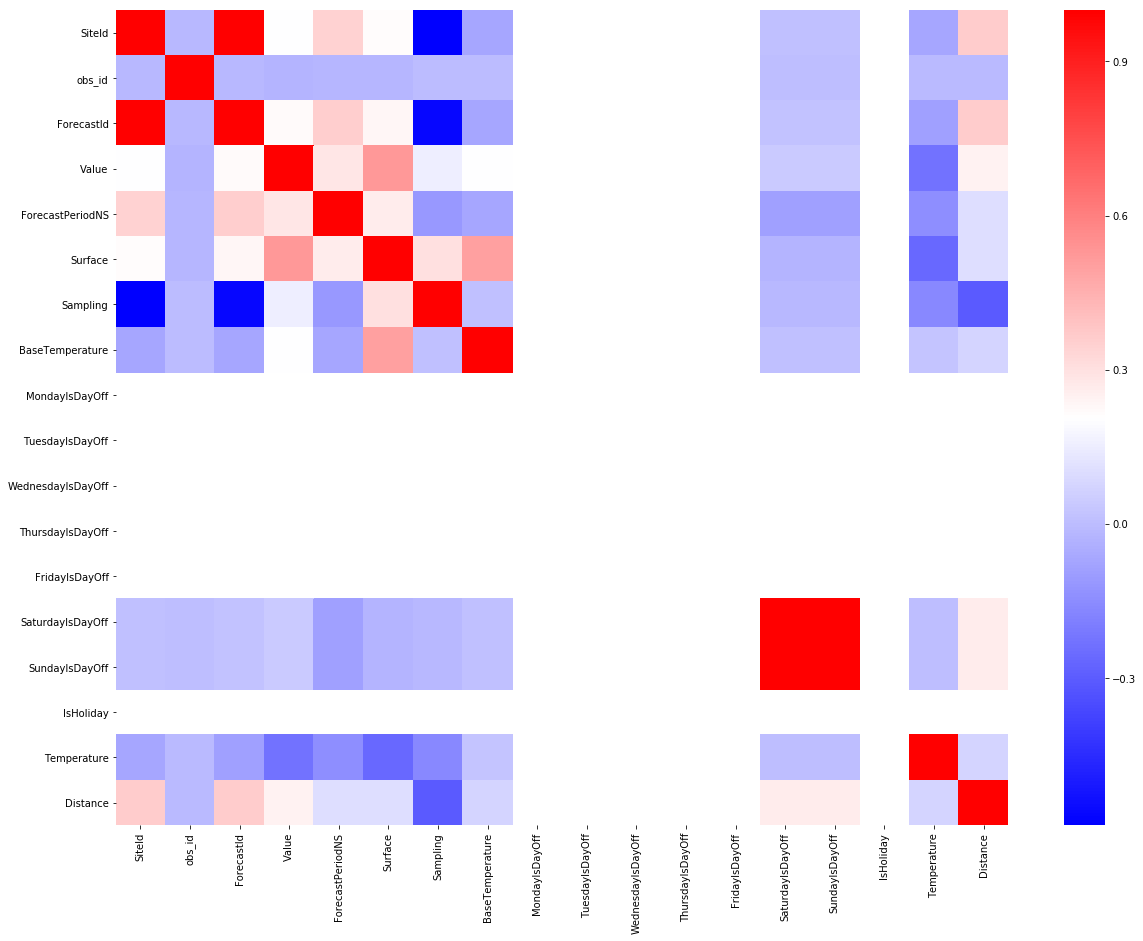

In [36]:
correlations = training_final.corr()
plt.figure(figsize = (20,15))
sns.heatmap(correlations, cmap='bwr')

In [37]:
# Correlation matrix that will give the exact corr value for variables
correlations

,SiteId,obs_id,ForecastId,Value,ForecastPeriodNS,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff,IsHoliday,Temperature,Distance
SiteId,1.000000,-0.015042,0.997354,0.205008,0.347130,0.216577,-0.587252,-0.069093,NaN,NaN,NaN,NaN,NaN,0.008767,0.008767,NaN,-0.071345,0.363464
obs_id,-0.015042,1.000000,-0.015857,-0.027166,-0.018357,-0.018074,-0.002585,-0.000078,NaN,NaN,NaN,NaN,NaN,0.002366,0.002366,NaN,-0.004868,-0.009833
ForecastId,0.997354,-0.015857,1.000000,0.223222,0.357863,0.232984,-0.568281,-0.070113,NaN,NaN,NaN,NaN,NaN,0.015994,0.015994,NaN,-0.088352,0.362776
Value,0.205008,-0.027166,0.223222,1.000000,0.285248,0.527850,0.155462,0.203696,NaN,NaN,NaN,NaN,NaN,0.039196,0.039196,NaN,-0.228950,0.245739
ForecastPeriodNS,0.347130,-0.018357,0.357863,0.285248,1.000000,0.267170,-0.111349,-0.071247,NaN,NaN,NaN,NaN,NaN,-0.085493,-0.085493,NaN,-0.142812,0.106661
Surface,0.216577,-0.018074,0.232984,0.527850,0.267170,1.000000,0.301369,0.502569,NaN,NaN,NaN,NaN,NaN,-0.028042,-0.028042,NaN,-0.261424,0.103368
Sampling,-0.587252,-0.002585,-0.568281,0.155462,-0.111349,0.301369,1.000000,0.010136,NaN,NaN,NaN,NaN,NaN,-0.012666,-0.012666,NaN,-0.159537,-0.304116
BaseTemperature,-0.069093,-0.000078,-0.070113,0.203696,-0.071247,0.502569,0.010136,1.000000,NaN,NaN,NaN,NaN,NaN,0.012708,0.012708,NaN,0.023933,0.071655
MondayIsDayOff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TuesdayIsDayOff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Modeling

In [55]:
X = training_final.drop(['Value'], axis=1)
X.head()

,Timestamp,SiteId,obs_id,ForecastId,ForecastPeriodNS,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff,IsHoliday,Temperature,Distance
0,2010-01-10,303,4144124.0,6962.0,8.640000e+13,17934.445927,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,0.535417,18.217638
1,2010-01-11,290,7540304.0,6462.0,8.640000e+13,34549.564657,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-0.825000,18.232985
2,2010-01-22,301,4977369.0,6720.0,8.640000e+13,21849.456801,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-0.637500,6.348075
3,2010-01-24,303,4853458.0,6962.0,8.640000e+13,17934.445927,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-0.825000,18.217638
4,2010-02-03,290,1375373.0,6462.0,8.640000e+13,34549.564657,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,-3.195833,18.232985


In [56]:
X['year'] = X['Timestamp'].apply(lambda x: x.year)
X['month'] = X['Timestamp'].apply(lambda x: x.month)
X['day'] = X['Timestamp'].apply(lambda x: x.day)
X = X.drop(['Timestamp'], axis=1)
X = X.fillna(0)
print(X.shape)
X.head()

(18873, 20)


,SiteId,obs_id,ForecastId,ForecastPeriodNS,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff,IsHoliday,Temperature,Distance,year,month,day
0,303,4144124.0,6962.0,8.640000e+13,17934.445927,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.535417,18.217638,2010,1,10
1,290,7540304.0,6462.0,8.640000e+13,34549.564657,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.825000,18.232985,2010,1,11
2,301,4977369.0,6720.0,8.640000e+13,21849.456801,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.637500,6.348075,2010,1,22
3,303,4853458.0,6962.0,8.640000e+13,17934.445927,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.825000,18.217638,2010,1,24
4,290,1375373.0,6462.0,8.640000e+13,34549.564657,15.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-3.195833,18.232985,2010,2,3


In [57]:
y = training_final['Value']
y.head()

0    1.080721e+07
1    8.018217e+06
2    1.872869e+06
3    1.080721e+07
4    8.091258e+06
Name: Value, dtype: float64

In [58]:
# set up the train test split 
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [59]:
#initiate linear regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [60]:
print(lr.score(X_test, y_test))

0.35393520530248146


In [61]:
# !pip install xgboost
# !pip install lightgbm
import xgboost as xgb
import lightgbm

In [63]:
dtrain = xgb.DMatrix(X_train)
dtest = xgb.DMatrix(X_test)